**Import necessary libraries:**

In [83]:
# data wrangling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# normalization
from scipy.stats import norm, boxcox_normmax
from scipy.special import boxcox1p

# miscellaneous
from collections import Counter

# machine learning
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from mlxtend.regressor import StackingCVRegressor

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

**Load the data:**

In [84]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
example = pd.read_csv("sample_submission.csv")

**Quick overview of the data:**

In [85]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [86]:
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [87]:
train.columns.size

81

In [88]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [89]:
test.columns.size

80

**SalePrice feature is not included in the test set since that's the variable we are going to predict.**

In [90]:
example.head()

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977


In [91]:
example.shape

(1459, 2)

**Combining the datasets will help us prepare them for modelling. Changes to combined dataset will affect both training and testing dataset and we can split them later.**

In [92]:
combine = pd.concat([train, test])

In [93]:
print("Training dataset (rows, columns):", train.shape)
print("Testing dataset (rows, columns):", test.shape)
print("Combined dataset (rows, columns):", combine.shape)
print("Submission example (rows, columns):", example.shape)

Training dataset (rows, columns): (1460, 81)
Testing dataset (rows, columns): (1459, 80)
Combined dataset (rows, columns): (2919, 81)
Submission example (rows, columns): (1459, 2)


## Exploratory Data Analysis (EDA)

**Transposing the description dataframe is making it easier for us to see all the features.**

In [94]:
train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Id,1460.0,730.500000,421.610009,1.0,365.75,730.5,1095.25,1460.0
MSSubClass,1460.0,56.897260,42.300571,20.0,20.00,50.0,70.00,190.0
LotFrontage,1201.0,70.049958,24.284752,21.0,59.00,69.0,80.00,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
OverallQual,1460.0,6.099315,1.382997,1.0,5.00,6.0,7.00,10.0
OverallCond,1460.0,5.575342,1.112799,1.0,5.00,5.0,6.00,9.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.00,1973.0,2000.00,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0
MasVnrArea,1452.0,103.685262,181.066207,0.0,0.00,0.0,166.00,1600.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.00,383.5,712.25,5644.0


In [95]:
test.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Id,1459.0,2190.000000,421.321334,1461.0,1825.50,2190.0,2554.50,2919.0
MSSubClass,1459.0,57.378341,42.746880,20.0,20.00,50.0,70.00,190.0
LotFrontage,1232.0,68.580357,22.376841,21.0,58.00,67.0,80.00,200.0
LotArea,1459.0,9819.161069,4955.517327,1470.0,7391.00,9399.0,11517.50,56600.0
OverallQual,1459.0,6.078821,1.436812,1.0,5.00,6.0,7.00,10.0
OverallCond,1459.0,5.553804,1.113740,1.0,5.00,5.0,6.00,9.0
YearBuilt,1459.0,1971.357779,30.390071,1879.0,1953.00,1973.0,2001.00,2010.0
YearRemodAdd,1459.0,1983.662783,21.130467,1950.0,1963.00,1992.0,2004.00,2010.0
MasVnrArea,1444.0,100.709141,177.625900,0.0,0.00,0.0,164.00,1290.0
BsmtFinSF1,1458.0,439.203704,455.268042,0.0,0.00,350.5,753.50,4010.0


In [96]:
combine.dtypes.value_counts()

object     43
int64      26
float64    12
dtype: int64

**Most of the variables are of the object (string) datatype which means we will most likely deal with a lot of categorical variables.**

### Target variable - SalePrice

In [97]:
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

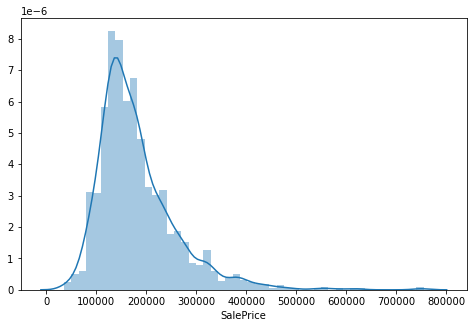

In [98]:
plt.figure(figsize=(8, 5))
sns.distplot(train['SalePrice'])
plt.show()

**We see from the plot that the distribution of sale prices deviates from the normal distribution and that the distribution is positively skewed.**

In [99]:
print("Skewness: %f" % train['SalePrice'].skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


### Relationship with other numerical variables

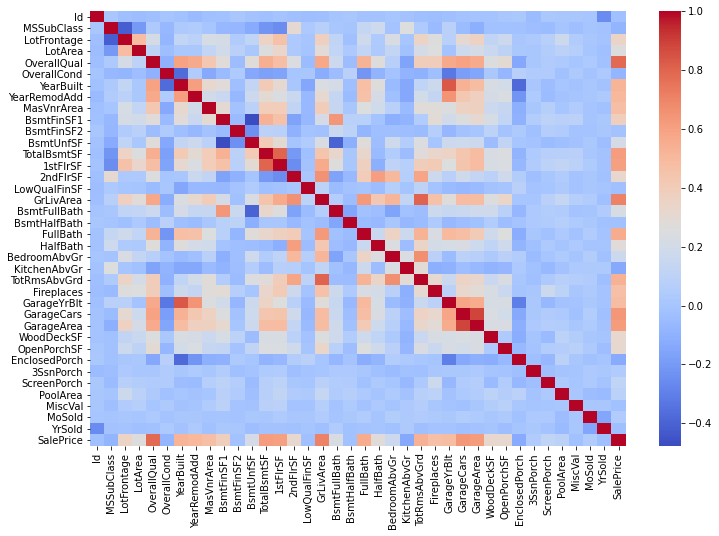

In [100]:
corr = combine.corr()
plt.figure(figsize = (12, 8))
sns.heatmap(corr, cmap = 'coolwarm')
plt.show()

**We can observe signs of multicollinearity in features: GarageYrBlt and YearBuilt, TotRmsAbvGrd and GrLivArea, GarageCars and GarageArea, TotalBsmtSF and 1stFlrSF.**

In [101]:
corr['SalePrice'].sort_values(ascending = False)[1:10]

OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
Name: SalePrice, dtype: float64

**Instead of examining all the correlated pairs, we will choose those features from each pair that have higher correlation to sale price. In other words, we will examine YearBuilt, GrLivArea, GarageCars, TotalBsmtSF. Not having highly correlated features in a regression model is very important. For the model to be stable, variance of the weight vector should be low. When we write a variance of a weight vector using SVD (Singular Value Decomposition), matrix S is going to have low values if we have highly correlated features in the dataset. Since we're taking inverse of it, S is going to be large, which makes variance of a weight vector large and that makes our model very sensitive to data which in return is going to make our model not perform well on the test data. So, it is advised that we keep only one feature in the dataset if two features are highly correlated.**

### Numerical variable - OverallQual

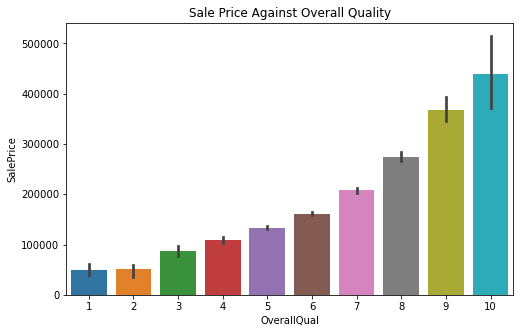

In [102]:
plt.figure(figsize=(8,5))
sns.barplot(x = 'OverallQual', y = 'SalePrice', data = train)
plt.title('Sale Price Against Overall Quality')
plt.show()

**As the overall quality of the house increases, so does its price.**

### Numerical variable - GrLivArea

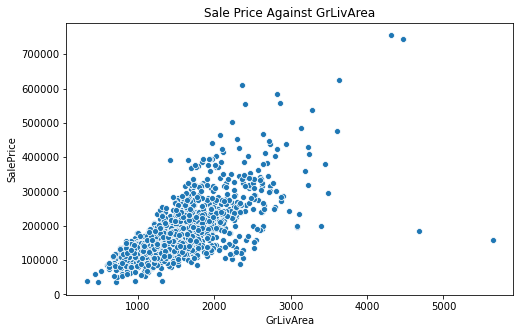

In [103]:
plt.figure(figsize=(8,5))
sns.scatterplot(x = 'GrLivArea', y = 'SalePrice', data = train)
plt.title('Sale Price Against GrLivArea')
plt.show()

**We can see couple of major outliers on the plot (big ground living room area, but small price). We will have to remove them later.**

### Numerical variable - GarageCars

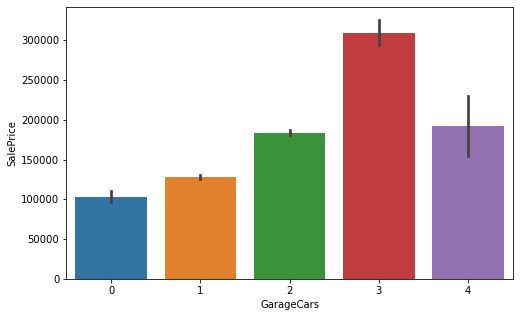

In [104]:
plt.figure(figsize=(8,5))
sns.barplot(x = 'GarageCars', y = 'SalePrice', data = train)
plt.show()

**Most expensive houses in our dataset have 3 garage cars.**

### Numerical variable - TotalBsmtSF

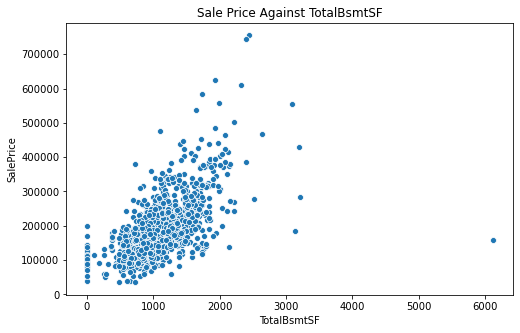

In [105]:
plt.figure(figsize=(8,5))
sns.scatterplot(x = 'TotalBsmtSF', y = 'SalePrice', data = train)
plt.title('Sale Price Against TotalBsmtSF')
plt.show()

**There are some outliers within this feature as well.**

### Numerical variable - YearBuilt

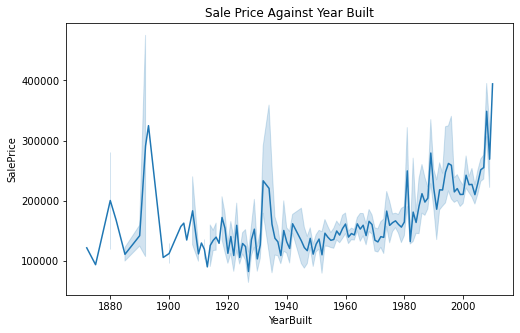

In [106]:
plt.figure(figsize=(8,5))
sns.lineplot(x = 'YearBuilt', y = 'SalePrice', data = train)
plt.title('Sale Price Against Year Built')
plt.show()

**Sale prices are trending upwards for newer houses in general.**

### Numerical variable - FullBath

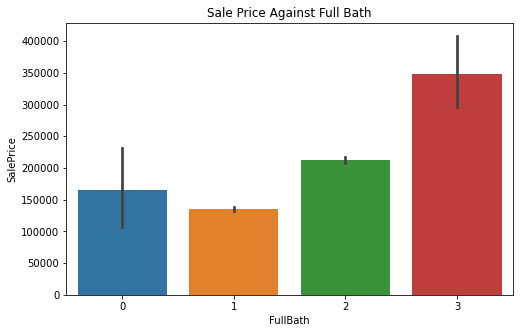

In [107]:
plt.figure(figsize=(8,5))
sns.barplot(x = 'FullBath', y = 'SalePrice', data = train)
plt.title('Sale Price Against Full Bath')
plt.show()

### More scatter plots

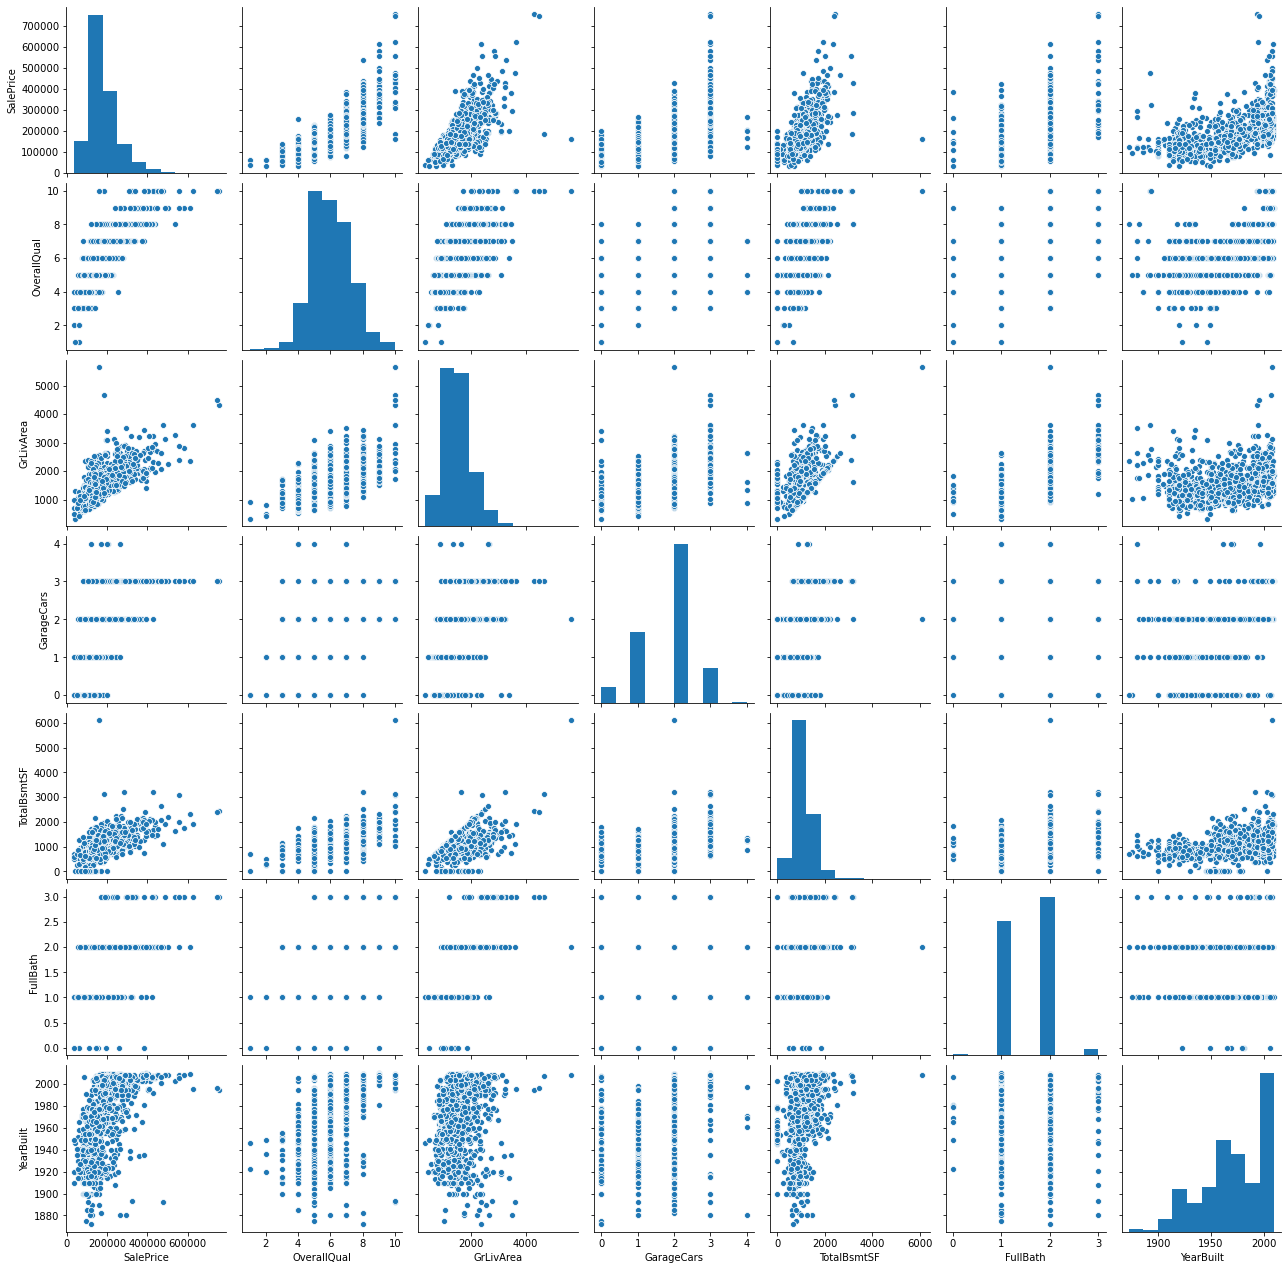

In [108]:
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(train[cols], height = 2.5)
plt.show();

### Missing data

In [109]:
missing = combine.isnull().sum()
missing = missing[missing > 0]

percentage_missing = missing / len(combine)
missing_df = pd.concat([missing, percentage_missing], axis = 1, keys = ['Total', 'Percent'])

missing_df = missing_df.drop('SalePrice')
missing_df.sort_values(by = 'Total', ascending = False, inplace = True)

In [110]:
missing_df

,Total,Percent
PoolQC,2909,0.996574
MiscFeature,2814,0.964029
Alley,2721,0.932169
Fence,2348,0.804385
FireplaceQu,1420,0.486468
LotFrontage,486,0.166495
GarageFinish,159,0.054471
GarageQual,159,0.054471
GarageCond,159,0.054471
GarageYrBlt,159,0.054471


**It's neater when we plot the missing values by features.**

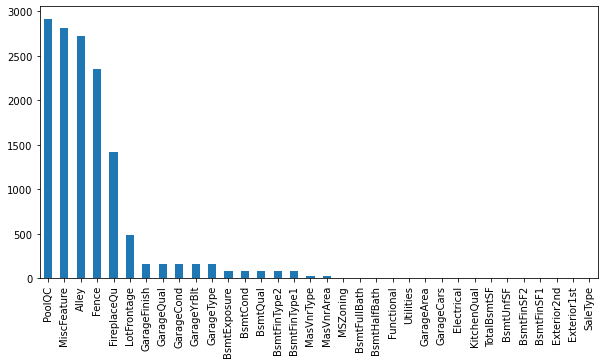

In [111]:
plt.figure(figsize = (10, 5))
missing_df['Total'].plot(kind = 'bar')
plt.show()

In [112]:
missing_features = missing_df.index
missing_features

Index(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'LotFrontage',
       'GarageFinish', 'GarageQual', 'GarageCond', 'GarageYrBlt', 'GarageType',
       'BsmtExposure', 'BsmtCond', 'BsmtQual', 'BsmtFinType2', 'BsmtFinType1',
       'MasVnrType', 'MasVnrArea', 'MSZoning', 'BsmtFullBath', 'BsmtHalfBath',
       'Functional', 'Utilities', 'GarageArea', 'GarageCars', 'Electrical',
       'KitchenQual', 'TotalBsmtSF', 'BsmtUnfSF', 'BsmtFinSF2', 'BsmtFinSF1',
       'Exterior2nd', 'Exterior1st', 'SaleType'],
      dtype='object')

## Data preprocessing

### Missing values
**Let's first impute missing values in garage features.**

In [113]:
garage_features = [feature for feature in missing_features if 'Garage' in feature]
garage_features

['GarageFinish',
 'GarageQual',
 'GarageCond',
 'GarageYrBlt',
 'GarageType',
 'GarageArea',
 'GarageCars']

In [114]:
combine[garage_features].dtypes

GarageFinish     object
GarageQual       object
GarageCond       object
GarageYrBlt     float64
GarageType       object
GarageArea      float64
GarageCars      float64
dtype: object

**There's 4 categorical features and we are going to impute them with 'None' and 3 numerical features that we are going to impute with 0.**

In [115]:
for feature in garage_features:
    if combine[feature].dtype == 'object':
        combine[feature] = combine[feature].fillna('None')
    else:
        combine[feature] = combine[feature].fillna(0)

**Now let's impute missing values in basement features.**

In [116]:
basement_features = [feature for feature in missing_features if 'Bsmt' in feature]
basement_features

['BsmtExposure',
 'BsmtCond',
 'BsmtQual',
 'BsmtFinType2',
 'BsmtFinType1',
 'BsmtFullBath',
 'BsmtHalfBath',
 'TotalBsmtSF',
 'BsmtUnfSF',
 'BsmtFinSF2',
 'BsmtFinSF1']

In [117]:
combine[basement_features].dtypes

BsmtExposure     object
BsmtCond         object
BsmtQual         object
BsmtFinType2     object
BsmtFinType1     object
BsmtFullBath    float64
BsmtHalfBath    float64
TotalBsmtSF     float64
BsmtUnfSF       float64
BsmtFinSF2      float64
BsmtFinSF1      float64
dtype: object

**We will repeat the same procedure for imputing basement features values.**

In [118]:
for feature in basement_features:
    if combine[feature].dtype == 'object':
        combine[feature] = combine[feature].fillna('None')
    else:
        combine[feature] = combine[feature].fillna(0)

**Missing values in Masonry veener features (walls that consist of a single non-structural external layer of masonry, typically made of brick, stone or manufactured stone).**

In [119]:
mv_features = [feature for feature in missing_features if 'MasVnr' in feature]
mv_features

['MasVnrType', 'MasVnrArea']

In [120]:
combine[mv_features].dtypes

MasVnrType     object
MasVnrArea    float64
dtype: object

**We will impute missing values in the same way as before.**

In [121]:
for feature in mv_features:
    if combine[feature].dtype == 'object':
        combine[feature] = combine[feature].fillna('None')
    else:
        combine[feature] = combine[feature].fillna(0)

**Let's now examine the rest of the features with missing values. There are a few of them, namely PoolQC, MiscFeature, Alley, Fence, and FireplaceQu whose missing values are indicating that the particular house simply doesn't have that feature. Therefore, we can fill them with 'None'.**

In [122]:
other_features = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu']
for feature in other_features:
    combine[feature] = combine[feature].fillna('None')

**Let's examine the situation with missing values now.**

In [123]:
missing = combine.isnull().sum()
missing = missing[missing > 0]
missing = missing.drop('SalePrice')
missing.sort_values(ascending = False, inplace = True)
missing

LotFrontage    486
MSZoning         4
Functional       2
Utilities        2
SaleType         1
KitchenQual      1
Electrical       1
Exterior2nd      1
Exterior1st      1
dtype: int64

In [124]:
missing_features = list(missing.index)
combine[missing_features].dtypes

LotFrontage    float64
MSZoning        object
Functional      object
Utilities       object
SaleType        object
KitchenQual     object
Electrical      object
Exterior2nd     object
Exterior1st     object
dtype: object

**The idea is to group LotFrontage values by the neighbourhood they're in and then impute the missing values with the median LotFrontage value in that particular neighbourhood. We will also impute MsZoning values by grouping them in MSSubClass categories and then taking the mode of MsZoning values in a specific category. We'll impute the missing values in rest of the features with the mode of those features.**

In [125]:
combine['LotFrontage'] = combine.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
combine['MSZoning'] = combine.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

missing_features.remove('LotFrontage')
missing_features.remove('MSZoning')
for feature in missing_features:
    combine[feature] = combine[feature].fillna(combine[feature].mode()[0])

**We'll make sure there's no more missing values.**

In [126]:
combine.drop('SalePrice', axis = 1).isnull().sum().max()

0

### Outliers
**We can split the combined dataset now into training and testing datasets.**

In [127]:
train = combine[:len(train)]
test = combine[len(train):]

**We'll drop the SalePrice feature from the testing dataset since it's the variable we are going to predict.**

In [128]:
test = test.drop('SalePrice', axis = 1)

In [129]:
print("Training set shape: ", train.shape)
print("Test set shape: ", test.shape)

Training set shape:  (1460, 81)
Test set shape:  (1459, 80)


**Let's get all the numerical features excluding Id and SalePrice.**

In [130]:
numerical_features = [feature for feature in train if train[feature].dtype != 'object']
numerical_features.remove('Id')
numerical_features.remove('SalePrice')

In [131]:
numerical_features

['MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold']

**Tukey’s rule says that the outliers are values more than 1.5 times the
interquartile range from the quartiles — either below Q1 −1.5IQR, or above
Q3 + 1.5IQR. We are going to use this rule to detect and remove outliers.**

In [132]:
def detect_outliers(df, n, features):
    outlier_indices = [] 
    for col in features: 
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3 - Q1
        outlier_step = 1.5 * IQR 
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        outlier_indices.extend(outlier_list_col)
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(key for key, value in outlier_indices.items() if value > n) 
    return multiple_outliers

outliers_to_drop = detect_outliers(train, 6, numerical_features)
print(f"There are {len(outliers_to_drop)} outliers detected.")

There are 9 outliers detected.


In [133]:
train.iloc[outliers_to_drop]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
635,636,190,RH,60.0,10896,Pave,Pave,Reg,Bnk,AllPub,...,0,None,None,None,0,3,2007,WD,Abnorml,200000.0
197,198,75,RL,174.0,25419,Pave,None,Reg,Lvl,AllPub,...,512,Ex,GdPrv,None,0,3,2006,WD,Abnorml,235000.0
523,524,60,RL,130.0,40094,Pave,None,IR1,Bnk,AllPub,...,0,None,None,None,0,10,2007,New,Partial,184750.0
1173,1174,50,RL,138.0,18030,Pave,None,IR1,Bnk,AllPub,...,0,None,MnPrv,None,0,3,2007,WD,Normal,200500.0
1182,1183,60,RL,160.0,15623,Pave,None,IR1,Lvl,AllPub,...,555,Ex,MnPrv,None,0,7,2007,WD,Abnorml,745000.0
1298,1299,60,RL,313.0,63887,Pave,None,IR3,Bnk,AllPub,...,480,Gd,None,None,0,1,2008,New,Partial,160000.0
185,186,75,RM,90.0,22950,Pave,None,IR2,Lvl,AllPub,...,0,None,GdPrv,None,0,6,2006,WD,Normal,475000.0
691,692,60,RL,104.0,21535,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,1,2007,WD,Normal,755000.0
1386,1387,60,RL,80.0,16692,Pave,None,IR1,Lvl,AllPub,...,519,Fa,MnPrv,TenC,2000,7,2006,WD,Normal,250000.0


In [134]:
print(f"Before: {len(train)} rows")
train = train.drop(outliers_to_drop).reset_index(drop = True)
print(f"After: {len(train)} rows")

Before: 1460 rows
After: 1451 rows


### Transformations

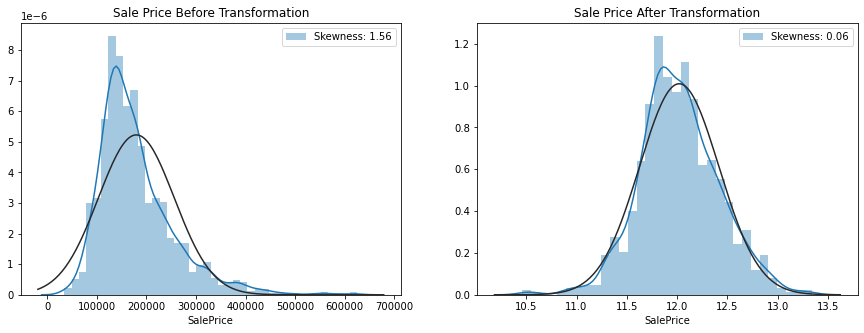

In [135]:
fig, ax = plt.subplots(1, 2)

sns.distplot(train['SalePrice'], fit = norm, label = 'Skewness: %.2f'%train['SalePrice'].skew(), ax = ax[0])
ax[0].legend(loc = 'best')
ax[0].title.set_text('Sale Price Before Transformation')

train['SalePrice'] = np.log1p(train['SalePrice'])

sns.distplot(train['SalePrice'], fit = norm, label = 'Skewness: %.2f'%train['SalePrice'].skew(), ax = ax[1])
ax[1].legend(loc = 'best')
ax[1].title.set_text('Sale Price After Transformation')

fig.set_figheight(5)
fig.set_figwidth(15)

**We'll apply Box-Cox transformation to numerical features with high skewness. A Box Cox transformation is a transformation of non-normal dependent variables into a normal shape. Let's first combine the datasets again since we're going to modify the features in both.**

In [136]:
combine = pd.concat([train, test])

In [137]:
skew_features = combine[numerical_features].apply(lambda x: x.skew()).sort_values(ascending = False)
high_skew = skew_features[skew_features > 0.5]
print(f"There are {len(high_skew)} numerical features with skew greater than 0.5. ")
high_skew

There are 26 numerical features with skew greater than 0.5. 


MiscVal          22.047916
PoolArea         21.196819
LowQualFinSF     13.416755
LotArea          13.176425
3SsnPorch        11.363981
KitchenAbvGr      4.315158
BsmtFinSF2        4.164170
BsmtHalfBath      3.955531
EnclosedPorch     3.953261
ScreenPorch       3.902134
MasVnrArea        2.600193
OpenPorchSF       2.537419
WoodDeckSF        1.847518
MSSubClass        1.374974
1stFlrSF          1.257911
LotFrontage       1.067293
BsmtFinSF1        0.975355
GrLivArea         0.947840
BsmtUnfSF         0.923233
2ndFlrSF          0.842849
Fireplaces        0.727687
TotRmsAbvGrd      0.702998
HalfBath          0.699605
TotalBsmtSF       0.666376
BsmtFullBath      0.623406
OverallCond       0.565995
dtype: float64

In [138]:
for feature in high_skew.index:
    combine[feature] = boxcox1p(combine[feature], boxcox_normmax(combine[feature] + 1))

## Feature engineering

In [139]:
combine.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

**Multiplying boolean values by 1 is going to give us 1 or 0 instead of True or False. The idea is to simplify the features by changing the values from numeric to something as simple as - "has a a certain house feature or doesn't".**

In [140]:
print(f"Before: {combine.shape[1]} columns")

Before: 81 columns


In [141]:
splitcombine['UnfBsmt'] = (combine['BsmtFinType1'] == 'Unf') * 1
combine['HasWoodDeck'] = (combine['WoodDeckSF'] == 0) * 1
combine['HasOpenPorch'] = (combine['OpenPorchSF'] == 0) * 1
combine['HasEnclosedPorch'] = (combine['EnclosedPorch'] == 0) * 1
combine['Has3SsnPorch'] = (combine['3SsnPorch'] == 0) * 1
combine['HasScreenPorch'] = (combine['ScreenPorch'] == 0) * 1
combine['HasPool'] = (combine['PoolArea'] == 0) * 1
combine['Has2ndFloor'] = (combine['2ndFlrSF'] == 0) * 1
combine['HasGarage'] = (combine['GarageArea'] == 0) * 1
combine['HasBsmt'] = (combine['TotalBsmtSF'] == 0) * 1
combine['HasFireplace'] = (combine['Fireplaces'] == 0) * 1

**YearRemodAdd** - Remodel date (same as construction date if no remodeling or additions)<br>
**YrSold** - Year Sold (YYYY)

In [142]:
combine['YearsSinceRemodel'] = combine['YrSold'].astype(int) - combine['YearRemodAdd'].astype(int)
combine['YearBuiltAndRemodel'] = combine['YearBuilt'] + combine['YearRemodAdd']

**We'll sum up related features to get the total amount of a certain metric.**

In [143]:
combine['TotalHomeQuality'] = combine['OverallQual'] + combine['OverallCond']
combine['TotalSF'] = combine['TotalBsmtSF'] + combine['1stFlrSF'] + combine['2ndFlrSF']
combine['TotalBathrooms'] = combine['FullBath'] + combine['BsmtFullBath'] + 0.5 * (combine['HalfBath'] + combine['BsmtHalfBath'])
combine['TotalPorchSF'] = combine['OpenPorchSF'] + combine['3SsnPorch'] + combine['EnclosedPorch'] + combine['ScreenPorch'] + combine['WoodDeckSF']

In [144]:
print(f"After: {combine.shape[1]} columns")

After: 98 columns


### Encoding categorical features

In [145]:
print("Before adding the encoded features: ", combine.shape)
combine = pd.get_dummies(combine)
print("After adding the encoded features: ", combine.shape)

Before adding the encoded features:  (2910, 98)
After adding the encoded features:  (2910, 319)


## Modelling

In [146]:
train = combine[:len(train)]
test = combine[len(train):]

In [147]:
X_train = train.drop(['Id', 'SalePrice'], axis = 1)
Y_train = train['SalePrice']
X_test = test.drop(['Id', 'SalePrice'], axis = 1)
test_id = test['Id']

In [148]:
print("X_train shape: ", X_train.shape)
print("Y_train shape: ", Y_train.shape)
print("X_test shape: ", X_test.shape)

X_train shape:  (1451, 317)
Y_train shape:  (1451,)
X_test shape:  (1459, 317)


### k-Fold Cross-Validation
**Cross-validation is a resampling procedure used to evaluate machine learning models on a limited data sample.
The procedure has a single parameter called k that refers to the number of groups that a given data sample is to be split into. In our example, we chose k = 10 therefore it's a 10-fold cross-validation.**

In [149]:
kfolds = KFold(n_splits = 10, shuffle = True, random_state = 42)

def cv_rmse(model, X = X_train, y = Y_train):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring = 'neg_mean_squared_error', cv = kfolds))
    return rmse

In [150]:
ridge = make_pipeline(RobustScaler(), RidgeCV())
lasso = make_pipeline(RobustScaler(), LassoCV())
elasticnet = make_pipeline(RobustScaler(), ElasticNetCV())
rf = RandomForestRegressor()
svr = SVR()
gbr = GradientBoostingRegressor()
lightgbm = LGBMRegressor()
xgboost = XGBRegressor()

In [151]:
models = [ridge, lasso, elasticnet, rf, svr, gbr, lightgbm, xgboost]
mean = []
std = []
for model in models:
    mean.append(cv_rmse(model).mean())
    std.append(cv_rmse(model).std())

models_df = pd.DataFrame({'Model': ['Ridge', 'Lasso', 'Elastic Net', 'Random Forest', 'SVR', 'Gradient Boosting', 'Light GBM', 'XGBoost'],
                         'Mean': mean, 'Std': std})
models_df.sort_values(by = 'Mean', inplace = True, ignore_index = True)

In [152]:
models_df

,Model,Mean,Std
0,Ridge,0.108821,0.014678
1,Lasso,0.111485,0.018167
2,Elastic Net,0.111738,0.018194
3,Gradient Boosting,0.121994,0.012655
4,Light GBM,0.124947,0.014556
5,Random Forest,0.134623,0.015436
6,XGBoost,0.135818,0.016157
7,SVR,0.190249,0.018410


## Prediction
**Ridge Regression is a technique for analyzing multiple regression data that suffer from multicollinearity. When 
multicollinearity occurs, least squares estimates are unbiased, but their variances are large so they may be far from 
the true value. By adding a degree of bias to the regression estimates, ridge regression reduces the standard errors.**

In [153]:
ridge_model = ridge.fit(X_train, Y_train)
Y_pred = ridge_model.predict(X_test)
len(Y_pred)

1459

In [154]:
example.shape

(1459, 2)

In [155]:
example.head()

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977


In [156]:
ridge_submission = pd.DataFrame({'Id': test_id, 'SalePrice': np.expm1(Y_pred)})
ridge_submission.head()

,Id,SalePrice
0,1461,117572.548806
1,1462,156062.774822
2,1463,185026.425978
3,1464,200000.165253
4,1465,192791.560804


In [157]:
ridge_submission.to_csv("~/Data Science/houses_final/submit.csv", index = False)